In [53]:
%load_ext cudf.pandas

import tqdm 
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [2]:
df = pd.read_csv('/workspace/Norway_Diskos_reports.csv')

In [11]:
n_records = df.shape[0]
n_records

2752381

In [13]:
f'{n_records:.3g}'

'2.75e+06'

In [3]:
df.nunique()

_id                                                   39217
filename                                              39217
page                                                    953
content                                             2175274
possible_language                                         2
langdetect                                          1970717
content_could_be_natural_language                         2
content_scrubbed_light                              2175089
content_scrubbed_light_could_be_natural_language          2
WELLBORE NAME                                          6456
WELL NAME                                              4183
TYPE                                                     30
INFO ITEM GROUP TYPE                                      9
INFO ITEM TYPE                                          258
TITLE                                                 19116
DESCRIPTION                                           36901
CREATOR BA NAME                         

In [4]:
summary_stats = df.describe()
summary_stats

/usr/local/lib/python3.10/dist-packages/cudf/core/dataframe.py:5062: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cudf/core/series.py:3334: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


,page,Short Dataset Id,PUBLIC ACCESS,Size,INFORMATION ITEM ID
count,2.752381e+06,2.748310e+06,2.752133e+06,2.752133e+06,2.752133e+06
mean,7.660669e+01,9.680482e+00,1.520988e+01,9.809937e+07,6.790041e+09
std,7.851666e+01,4.436844e+00,7.954682e+00,1.960028e+08,4.127468e+09
min,1.000000e+00,2.070000e+00,2.000000e+00,4.456000e+03,2.558304e+08
25%,2.100000e+01,5.110000e+00,2.000000e+00,6.078469e+06,1.765909e+09
50%,5.100000e+01,1.107000e+01,2.000000e+01,1.972244e+07,1.007452e+10
75%,1.050000e+02,1.405000e+01,2.000000e+01,9.605392e+07,1.017842e+10
max,9.610000e+02,9.901000e+01,2.000000e+01,2.046255e+09,1.018118e+10


In [5]:
# 2. Count of pages per document
pages_per_document = df['filename'].value_counts()
pages_per_document

2_7-26 S__ROCK AND CORE__GCH_REPORT_3.PDF               950
25_11-A-6 AH__DRILLING__COMPLETION_PROGRAMME.pdf        710
25_11-A-6 H__DRILLING__COMPLETION_PROGRAMME.pdf         710
7321_8-1__ROCK AND CORE__GCH_1987-12-31_REPORT_1.PDF    610
6406_2-2__ROCK AND CORE__GCH_1996-08-31_REPORT_2.pdf    600
                                                       ... 
8_3-2__PETROPHYSICS__PETROPHYSICAL_REPORT_2.PDF           1
8_3-2__WELL SEISMIC__VELOCITY_REPORT_1.PDF                1
9_2-2__DRILLING__DRILLING_REPORT_2.PDF                    1
9_4-3__WELL SEISMIC__09-04-03_PB-707-1054.PDF             1
9_4-3__WELL__09-04-03_PB-707-1055.PDF                     1
Name: filename, Length: 39217, dtype: int64

In [19]:
# 3. Count of documents per wellbore
documents_per_gr_type = df.groupby('INFO ITEM GROUP TYPE')['filename'].nunique()

documents_per_gr_type = documents_per_gr_type.sort_values(ascending=False)

documents_per_gr_type

INFO ITEM GROUP TYPE
TEST FLUID AND PRESSURE    8350
DRILLING                   7352
ROCK AND CORE              6691
WELL                       4690
WELL SEISMIC               3393
GEOLOGY                    3386
WELL LOG                   2743
PETROPHYSICS               1338
WELL PATH                  1272
Name: filename, dtype: int32

Text(0, 0.5, '# of docs')

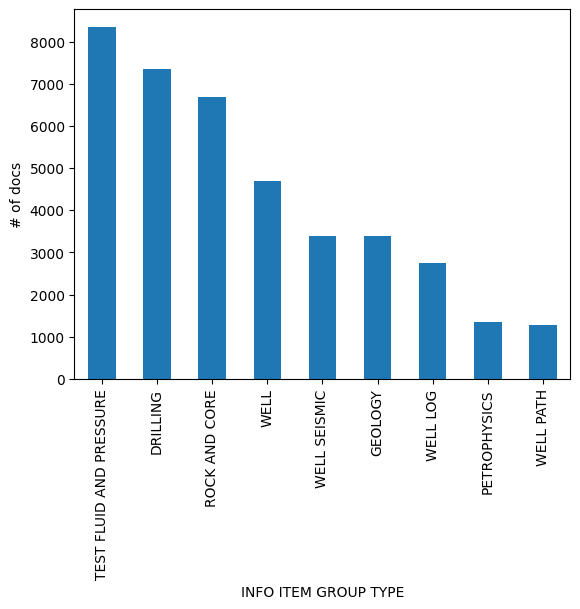

In [20]:


fig, ax = plt.subplots()
documents_per_gr_type.plot(kind='bar', ax=ax)
ax.set_ylabel('# of docs')

In [21]:
# 4. Count of document types per type grouping

document_types_per_grouping = df.groupby('INFO ITEM GROUP TYPE')['INFO ITEM TYPE'].nunique()

document_types_per_grouping = document_types_per_grouping.sort_values(ascending=False)

In [8]:
# 5. Count of pages per document type
pages_per_document_type = df.groupby('INFO ITEM TYPE')['page'].count()

pages_per_document_type.sort_values(ascending=False)

INFO ITEM TYPE
WELLBORE_DOCUMENTS           473255
COMPLETION_REPORT            326883
GEOCHEMISTRY                 309302
TEST_DATA                    269033
GEOLOGY                      176760
                              ...  
OLD_SITE_SURVEY_REPORT            2
WELL_TEST1_REPORT3                2
CORE_DESC_REPORT4                 1
OLD_BIOSTRAT_REPORT               1
OLD_WL_COMPUTED_PROD_PLOT         1
Name: page, Length: 258, dtype: int64

In [9]:


document_types_per_grouping = df.groupby('INFO ITEM GROUP TYPE')['document type'].nunique()

KeyError: 'Column not found: document type'

In [29]:
# Group by 'document type' and 'type grouping' and count the number of records in each group
grouped = df.groupby(['INFO ITEM TYPE', 'INFO ITEM GROUP TYPE']).size().reset_index(name='counts')

# If a 'document type' belongs to multiple 'type grouping', it will appear more than once in the grouped dataframe
duplicated_document_types = grouped['INFO ITEM TYPE'].duplicated()


# Check if there are any duplicated 'document type'
if duplicated_document_types.any():
    print("Some 'INFO ITEM TYPE' belong to multiple 'INFO ITEM GROUP TYPE'. Here they are:")
    print(grouped[duplicated_document_types])
else:
    print("Each 'INFO ITEM TYPE' belongs to exactly one 'INFO ITEM GROUP TYPE'.")

Some 'INFO ITEM TYPE' belong to multiple 'INFO ITEM GROUP TYPE'. Here they are:
             INFO ITEM TYPE INFO ITEM GROUP TYPE  counts
12                CORE_DATA        ROCK AND CORE  149377
147  OLD_WELLBORE_DOCUMENTS                 WELL      97
187      WELLBORE_DOCUMENTS                 WELL  129800
188      WELLBORE_DOCUMENTS             WELL LOG    7381


In [31]:
grouped

,INFO ITEM TYPE,INFO ITEM GROUP TYPE,counts
0,COMPLETION_REPORT,WELL,326883
1,COMPLETION_REPORT1,WELL,3555
2,COMPLETION_REPORT2,WELL,1775
3,COMPLETION_REPORT3,WELL,4
4,COMPLETION_REPORT_1,WELL,618
...,...,...,...
257,WL_MWD,WELL LOG,59657
258,WL_MWD_BIT_RUNS,WELL LOG,195
259,WL_PROD,WELL LOG,3534
260,WL_PROD_REPORT,WELL LOG,75


In [55]:
file_ids = df['_id'].unique()



# To pick 10 random values from the array
random_values = np.random.choice(file_ids, 10)

print(random_values)

['1cfbbfe2a67fd062e5a61e01ade5d5e2524b828c'
 '76a42851cba12ecc7e639f4318425063ea819752'
 'f8572c4291cea3da4ed8e0ed6cc50416ba9db5c5'
 '3f61e3375530a42d99b1b2419edafd6f18cee3d7'
 '00fc09b5b8133bcb4209277caeca86dc915f7fbc'
 'ed81a165efb8be40af654e5662481c2d18e52a51'
 '948432543f1649b5f0db9a1300ce5d39ad1c5a94'
 '2c6a8dc6a2b07c1d3725c61f9bd50642ba7258e6'
 '8d7a3790e099a46f96d94667579770a232e39cf5'
 'b2256779fd78a42ad6472bd9cae1eef5a484a7d2']


In [67]:
file_ids.shape

(39217,)

In [68]:
raw_folder = r'/workspace/local_data/raw'
os.makedirs(raw_folder, exist_ok=True)

for document in tqdm.tqdm(file_ids):
	document_query = df.query('_id == @document')

	with open(f"{raw_folder}/{document}.jsonl", "w") as f:

		for idx, row in tqdm.tqdm(document_query.iterrows()):
			
			page = row['content']
			
			f.write(json.dumps({"text": page})+ "\n")

  0%|          | 0/39217 [00:00<?, ?it/s]

In [62]:
!text_cleaning --input-data-dir /workspace/local_data/raw --output-clean-dir /workspace/local_data/clean

[1717965781.770467] [38acad5fa44b:363447:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965826.104227] [38acad5fa44b:364497:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965826.467739] [38acad5fa44b:364578:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965827.109501] [38acad5fa44b:364574:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965827.650463] [38acad5fa44b:364591:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965827.665609] [38acad5fa44b:364598:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965827.730352] [38acad5fa44b:364592:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717965827.841355] [38acad5fa44b:364587:f]        vfs_fuse.c:

In [63]:
raw_folder = r'/workspace/local_data/raw'
os.makedirs(raw_folder, exist_ok=True)

for document in tqdm.tqdm(random_values[:3]):
	document_query = df.query('_id == @document')

	with open(f"{raw_folder}/{document}.jsonl", "w") as f:

		for idx, row in tqdm.tqdm(document_query.iterrows()):
			
			page = row['content']
			
			f.write(json.dumps({"text": page})+ "\n")

100%|██████████| 3/3 [02:17<00:00, 45.78s/it]


In [64]:
!text_cleaning --input-data-dir /workspace/local_data_test_v2/raw --output-clean-dir /workspace/local_data_test_v2/clean

[1717966508.566813] [38acad5fa44b:416097:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966553.377092] [38acad5fa44b:417170:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966553.494445] [38acad5fa44b:417184:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966554.168403] [38acad5fa44b:417183:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966554.380849] [38acad5fa44b:416905:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966554.555113] [38acad5fa44b:417168:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966554.907705] [38acad5fa44b:417247:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717966555.010244] [38acad5fa44b:417291:f]        vfs_fuse.c:

In [60]:
document_query

['WCS atis 15 NAI3Cs. 0(03qt-la5- bp BP Norge AS Cover Page Proprietary Information This Drawing/Report/Document contains proprietary information belonging to BP and may not be wholly or partially reproduced nor disclosed without prior written permission of BP Norge AS. Date Sign he Rev No Reason for issue/revision Prepled Checked Verified C. Brandasu R. Emberland Richard Smith Approved T. Mosness Document Type: FINAL WELL REPORT Replaces Document Number: Document Title: Well 2/8-F-15 T10 FINAL WELL REPORT - DRILLING Document Number: \\\\Eustvs20f\\Projects\\P0016 Valhall WP\\02_08-F 15\\ J15 - PROJECT FILES \\12 WELL FELES\\21 - End of Well Report Rev. NOR-1020/1(11/93)',
 ". bp VALHALL WP 2/8 F-15 T10 FINAL WELL REPORT, DRILLING Date: 03/04/2002 Rev: Table of Contents 1. GENERAL INFORMATION 1.1 Summary 1.2 Basic Well Data 1.3 Slot Designation 1.4 Casing Schematic 1.5 Completion Diagram F-15 2. LESSONS LEARNED 2.1 16 Section 2.2 12-1/4 14 Section 2.4 8-1/2 Section — Reservoir 2.5 Comp

In [44]:
os.makedirs("/workspace/local_data/raw", exist_ok=True)


# Get unique values in column 'A'
unique_values = df['_id'].unique()[:3]

for document in unique_values:
	print(document)

	# Filter rows with the current unique value in column 'A'
	filtered_df = df.query('_id == @document')['content']
	

# filtered_df


    


5bfcf09ed9ae404ad4bbd69af86af9e1cd6f4f6d
acfa805ed70ba003fd575c13f3c3e79e6fe68981
968b54cf2ec914a9de265b86c82eadb580594e9d


In [46]:
grouped = df.groupby('_id')
grouped

In [49]:
# Group the DataFrame by document
grouped = df.groupby('_id')

# For each document
for name, group in grouped:
    # Combine all pages into a single string
    content = group['content'].str.cat(sep=' ')

    # Create a dictionary to represent the document
    document = {
        'document': name,
        'content': content
    }

    # Convert the dictionary to a JSON string
    json_str = json.dumps(document)

    # Write the JSON string to a .jsonl file
    with open(f'/workspace/local_data/raw/{name}.jsonl', 'w') as f:
        f.write(json_str + '\\n')

# Print a success message
print("All documents have been compiled into individual .jsonl files.")

All documents have been compiled into individual .jsonl files.


In [50]:
import nemo_curator as nc
from nemo_curator.datasets import DocumentDataset
from nemo_curator.utils.file_utils import get_all_files_paths_under
from nemo_curator.filters import WordCountFilter


In [ ]:

# Get a list of all files in the given directory
files = get_all_files_paths_under("your_dataset_directory/")

# Read the files into memory
dataset = DocumentDataset.read_json(files, add_filename=True)

# Construct and apply a heuristic filter for the length of the document
filter_step = nc.ScoreFilter(WordCountFilter(min_words=80), text_field="text", score_field="word_count")
filtered_dataset = filter_step(dataset)

# Write the filtered dataset back to disk
filtered_dataset.to_json("your_output_directory/", write_to_filename=True)


In [ ]:
df.groupby()

In [ ]:
with open("/workspace/data/raw/documents.jsonl", "w") as f:
    for document in tqdm.tqdm(documents):
        document = document.strip().replace("84th EAGE Annual Conference & Exhibition  ", "")
        f.write(json.dumps({"text": document}) + "\n")

In [35]:
df['_id'].unique()[:10]

array(['5bfcf09ed9ae404ad4bbd69af86af9e1cd6f4f6d',
       'acfa805ed70ba003fd575c13f3c3e79e6fe68981',
       '968b54cf2ec914a9de265b86c82eadb580594e9d',
       '356bfd8766a2f984d2720d88cfdf12da4af2c844',
       '601bf456b3eaa522e3692fed23fa249c00b4cb7c',
       '088b2ccf25be04bc691d37b38ecccab0e3ed0f25',
       'e0b8e9b9b18b1d02445a4782a8d90d75ed441482',
       'aaed5c16db1aed9cff3819f71873af1cfb4c38ff',
       '27365cddd6c7acede1239dbd7c4afc870f1df962',
       'bf825c8a8db1a57d1c0b818b7071a714303ecc7e'], dtype=object)

In [36]:
# Create the directory
os.makedirs('/workspace/local_data/raw', exist_ok=True)


# Get unique values in column 'A'
unique_values = df['_id'].unique()[:10]

# Iterate over unique values
for value in unique_values:
    # Filter rows with the current unique value in column 'A'
    filtered_df = df[df['_id'] == value]
    
    # Get the data in column 'B' as a list
    data = {'text': filtered_df['content'].to_list()}
    
    # Create a JSON file for the current unique value
    with open(f'/workspace/local_data/raw/{value}.jsonl', 'w') as f:
        json.dump(data, f)




In [51]:
!text_cleaning --input-data-dir /workspace/local_data_test/raw --output-clean-dir /workspace/local_data_test/clean

[1717964242.104145] [38acad5fa44b:304052:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964302.094491] [38acad5fa44b:304843:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964307.588160] [38acad5fa44b:305036:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964307.642389] [38acad5fa44b:304882:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964309.492511] [38acad5fa44b:305027:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964310.368489] [38acad5fa44b:305124:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964312.136690] [38acad5fa44b:305170:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
[1717964313.449981] [38acad5fa44b:305207:f]        vfs_fuse.c:

In [6]:
filtered_df['content'].to_list()

['tiorenoie izeopnysics vision LTD - F:1 .7. L. nloc,s 35,fro / ki5ob 15303(1 DEN NORSKE STATS OLJESELSKAP A$. WELL: 35/10-1 VERTICAL SEISMIC PROFILE REPORT A Itaythen C,cmparry',
 'S WELL: 35/10-1 RIG SOURCE SURVEY LIST OF CONTENTS VSP Processing Comment Depth/Stack List Field Acquisition Details SEG NORMAL DISPLAYS: Stacked Geophone Data with F-K Display VA1-4(FK) Downgoing Wavefield : Preliminary Filter Upgoing Wavefield with F-K Display VC(FK) Upgoing Wavefield (enhanced) (Display VD) (Display VA) (Display VB1) (Display VC) Deconvolved Upgoing Wavefield (Display VE) with F-K Display VE(FK) (Minimum Phase ) Deconvolved Upgoing Wavefield (enhanced) (Display VF) Deconvolved Downgoing Wavefield (Display VH) Residual Wavefield (Display VI) SEG REVERSE POLARITY DISPLAYS: Downgoing Wavefield (Display VB1) Upgoing Wavefield (Display VC) Upgoing wavefield (enhanced) (Display VD) /continued......',
 'Page Deconvolved Upgoing Wavefield Deconvolved Upgoing Wavefield (enhanced) Appendix (Descri